In [1]:
from tletools import TLE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from matplotlib import font_manager as fm
from tqdm import tqdm 
from matplotlib import ticker

# No need to run

In [5]:
tle_file=[]
g = os.walk(r"../Dataset/tle_data/")
for path,dir_list,file_list in g:  
     for file_name in file_list:  
            tle_file.append(os.path.join(path, file_name))
print(tle_file)

['../Dataset/tle_data/06_01_05tle.json', '../Dataset/tle_data/04_30_05_05_tle.json', '../Dataset/tle_data/05_28_31tle.json', '../Dataset/tle_data/05_24_28tle.json', '../Dataset/tle_data/05_05_10tle.json', '../Dataset/tle_data/04_20_25_tle.json', '../Dataset/tle_data/04_15_20_tle.json', '../Dataset/tle_data/05_20_24tle.json', '../Dataset/tle_data/05_15_20tle.json', '../Dataset/tle_data/04_25_30_tle.json', '../Dataset/tle_data/05_10_15tle.json']


In [6]:
datalist=[]
for i in tqdm(range(len(tle_file))):
    t_file=tle_file[i]
    with open(t_file,"r") as f:
#         datalist += json.load(f,strict=False)
        try:
            datalist += json.load(f)
        except:
            print(t_file)
        f.close()
print(len(datalist))

100%|██████████| 11/11 [00:20<00:00,  1.90s/it]

2390204


In [7]:
data={}
data["DEBRIS"]={}
data["PAYLOAD"]={}
data["Starlink"]={}
data["UNKNOWN"]={}
for item in data.values():
    item["bstar"]=[]
    item["inc"]=[]
    item["n"]=[]
    item["ecc"]=[]
    item["raan"]=[]
    item["M"]=[]
    item["omega"]=[]
    item["revs"]=[]

In [5]:
print(data)

{'DEBRIS': {'bstar': [], 'inc': [], 'n': [], 'ecc': [], 'raan': [], 'M': [], 'omega': [], 'revs': []}, 'PAYLOAD': {'bstar': [], 'inc': [], 'n': [], 'ecc': [], 'raan': [], 'M': [], 'omega': [], 'revs': []}, 'Starlink': {'bstar': [], 'inc': [], 'n': [], 'ecc': [], 'raan': [], 'M': [], 'omega': [], 'revs': []}, 'UNKNOWN': {'bstar': [], 'inc': [], 'n': [], 'ecc': [], 'raan': [], 'M': [], 'omega': [], 'revs': []}}


In [8]:
def get_param(datalist):
    for i in range(len(datalist)):
        item=datalist[i]
        try:
            obj_type=item["OBJECT_TYPE"]
            if obj_type=="ROCKET BODY":
                obj_type="DEBRIS"
            if item['OBJECT_NAME'].startswith('STARLINK') and not item['OBJECT_NAME'].endswith('(DARKSAT)'):
                obj_type="Starlink"
            line=item["TLE_LINE0"]
            line1=item["TLE_LINE1"]
            line2=item["TLE_LINE2"]
            tle_lines=[line,line1,line2]
            tle = TLE.from_lines(*tle_lines)
            
            data[obj_type]["bstar"].append(tle.bstar)
            data[obj_type]["inc"].append(tle.inc)
            data[obj_type]["n"].append(tle.n)
            data[obj_type]["ecc"].append(tle.ecc)
            data[obj_type]["raan"].append(tle.raan)
            data[obj_type]["M"].append(tle.M)
            data[obj_type]["omega"].append(tle.argp)
            data[obj_type]["revs"].append(tle.rev_num)
        except:
            print("error")
    return data
data=get_param(datalist)

In [13]:
np.save('data.npy',data)

## Start from this line

In [5]:
data = np.load('./data/data.npy',allow_pickle=True).item()

In [3]:
def get_range(data,item):
    top=-1
    bottom=-1
    for k,v in data.items(): 
            t=max(v[item])
            t_min=min(v[item])
            if t_min<0:
                print(t_min)
            if top==-1 :
                top=t
                bottom=t_min
            else:
                top=max(top,t)
                bottom=min(bottom,t_min)
    return bottom,top
# t,b=get_range(data,'bstar')

# Orbital parameter distributions in dataset

-0.97965
-0.9994
-0.075677
-4.5712


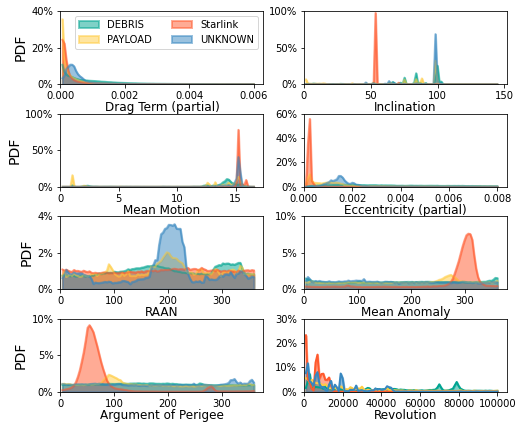

In [6]:

fig_name={"bstar":"Drag Term (partial)","inc":"Inclination","n":"Mean Motion","ecc":"Eccentricity (partial)","raan":"RAAN","M":"Mean Anomaly","omega":"Argument of Perigee","revs":"Revolution"}
p_name=["bstar","inc","n","ecc","raan","M","omega","revs"]
top=[0.4,1,1,0.6,0.04,0.1,0.1,0.3]
#Right Ascension\n of the Ascending Node
fig,axes = plt.subplots(4,2,figsize = (8,7))
plt.subplots_adjust(wspace =0.2, hspace =0.4)#调整子图间距
for i in range(8):
    # column:type
    # index:bins_count
    # data: count
    d={}
    t,b=get_range(data,p_name[i])
    if i==0:
        t=0
        b=0.006
    if i==3:
        b=0.008
    # print(t,b)
    for k,v in data.items(): 
        count, bins_count = np.histogram(v[p_name[i]], bins=100,range=(t,b))
        pdf = count / sum(count)
        d[k]=pd.Series(pdf, index=bins_count[1:])
    df1 = pd.DataFrame(d)
    df1.plot.area(color=["#00A491","#FFCD43","#FF592D","#3787C0"],alpha=0.5,stacked=False,ax = axes[i//2,i%2],legend=False,lw=2)
    axes[i//2,i%2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
#     axes[i//4,i%4].set_title(fig_name[p_name[i]],fontsize=12)
    axes[i//2,i%2].set_xlabel(fig_name[p_name[i]],size=12,labelpad=0.1)
    axes[i//2,i%2].set_xlim(left=0)
    axes[i//2,i%2].set_ylim(0,top[i])
    if i%2==0:
        axes[i//2,i%2].set_ylabel("PDF",size=14)
    i=i+1
for l in fig.gca().lines:
    l.set_alpha(1)
axes[0,0].legend(ncol=2)
plt.savefig('figure9.pdf')